<a href="https://colab.research.google.com/github/eneskacan/agu-capstone/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vehicle Classification via Machine Learning

### 1. Introduction
Vehicle classification is an important part of Intelligent Transportation System (ITS). Magnetic sensors are seen as a suitable solution for vehicle classification, considering the advantages such as ease of installation and maintenance, less exposure to weather conditions, and cost effectiveness.

In this project, total of 376 vehicle signals collected by a single 3-D magnetic sensor, will be analyzed to develop a machine learning model that classifies different types of vehicles.

### 2. Data Overview
The dataset contains a total of 376 vehicles signals collected by a single 3D magnetic sensor. Each vehicle sample contains 621 features, 207 for each of the X, Y, and Z signals, and signal lengths vary from sample to sample since some of the vehicles pass the sensor rapidly. Finally, each sample is labelled as vehicle type including motorcycles, hatchbacks, sedans, SUVs and buses.


In [1]:
# Import dataset (class_5.csv)
import pandas as pd

# Define external URLs
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/eneskacan/agu-capstone/main/"
VEHICLES_DATA = DOWNLOAD_ROOT + "dataset/class_5.csv"

X_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , :-1] # drop the last column
y_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , -1:] # pick the last column

vehicle_df = pd.concat([X_df, y_df], axis=1)

pd.set_option("display.max_columns", 15) # limit max number of columns displayed
vehicle_df.head()

,0,1,2,3,4,5,6,...,615,616,617,618,619,620,621
0,-4646,-4635,-4621,-4622,-4637,-4689,-4789,...,0,0,0,0,0,0,hatchback
1,-4500,-4551,-4581,-4529,-4514,-4564,-4616,...,0,0,0,0,0,0,hatchback
2,-4333,-4326,-4329,-4329,-4327,-4331,-4325,...,0,0,0,0,0,0,hatchback
3,-4308,-4304,-4300,-4302,-4293,-4284,-4270,...,0,0,0,0,0,0,hatchback
4,-4765,-4763,-4766,-4757,-4758,-4754,-4755,...,0,0,0,0,0,0,hatchback


### 3. Data Manipulation
In order to have better accuracy, missing data needs to be processed. And this will be done in 4 steps that are creating, completing, cleaning, and completing.

#### 3.1  Completing and Creating
It is possible to create new features by using existing columns in order to use data more efficiently. Instead of using raw signals, some of the measures of central tendency and distribution, including mean, max, minimum values, and standard deviation can be used in order to have a better performance.

In [2]:
# Create new features
import numpy as np

X_df = X_df.replace(0, np.NaN) # replace zeros with null

# Find mean values for each signal
X_df['x_avg'] = X_df.iloc[:, 000:206].mean(axis=1)
X_df['y_avg'] = X_df.iloc[:, 207:414].mean(axis=1)
X_df['z_avg'] = X_df.iloc[:, 415:621].mean(axis=1)

# Find minimum values for each signal
X_df['x_min'] = X_df.iloc[:, 000:206].min(axis=1)
X_df['y_min'] = X_df.iloc[:, 207:414].min(axis=1)
X_df['z_min'] = X_df.iloc[:, 415:621].min(axis=1)

# Find maximum values for each signal
X_df['x_max'] = X_df.iloc[:, 000:206].max(axis=1)
X_df['y_max'] = X_df.iloc[:, 207:414].max(axis=1)
X_df['z_max'] = X_df.iloc[:, 415:621].max(axis=1)

# Find standard deviation for each signal
X_df['x_std'] = X_df.iloc[:, 000:206].std(axis=1)
X_df['y_std'] = X_df.iloc[:, 207:414].std(axis=1)
X_df['z_std'] = X_df.iloc[:, 415:621].std(axis=1)

#### 3.2 Converting
***`Brief explanation of new vehicle classes will be here.`***

In [3]:
# Convert vehicle types
s_map = {'motorcycle': 'light', 
         'hatchback': 'medium', 'sedan': 'medium', 'suv': 'medium', 
         'truck':'heavy'}

# y2_df = pd.DataFrame()
# y2_df['class'] = y_df.iloc[:, 0].map(s_map)
y_df.iloc[:, 0] = y_df.iloc[:, 0].map(s_map)

#### 3.3 Cleaning
After creating required features from existing attributes, unnecessary columns can be removed in order to keep the data tidy and make the further processes simple and easier.

In [4]:
# Drop redundant columns
X_df.drop(X_df.iloc[:, 0:621], inplace = True, axis = 1)

***`Brief introduction of final dataset will be here.`***




In [5]:
X_df.head()

,x_avg,y_avg,z_avg,x_min,y_min,z_min,x_max,y_max,z_max,x_std,y_std,z_std
0,-4597.514286,4013.457143,2659.823529,-4953.0,3276.0,1285.0,-4253.0,4894.0,3116.0,172.609790,323.271179,434.298003
1,-4612.208333,4118.333333,2853.304348,-4711.0,4077.0,2800.0,-4500.0,4180.0,2985.0,59.071055,29.052676,65.952762
2,-4332.577778,4061.088889,2911.539326,-4490.0,3888.0,2727.0,-4135.0,4226.0,3162.0,82.825385,102.943275,115.442927
3,-4250.776316,4071.842105,2918.973333,-4487.0,3989.0,2672.0,-3981.0,4239.0,3163.0,157.309851,62.855613,141.272879
4,-4734.907407,4035.425926,2889.094340,-4789.0,3861.0,2764.0,-4516.0,4227.0,3046.0,58.869625,78.088146,95.746513


### 4. Split Dataset
***`Add brief explanation.`***

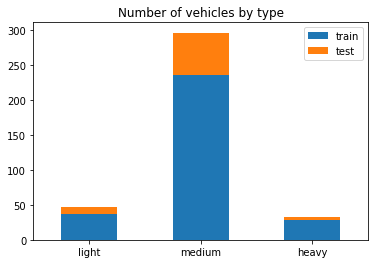

In [6]:
# Split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)

# Count vehicle types
count_train = y_train.apply(pd.value_counts).rename(columns={y_train.columns[0]:'train'}).T
count_test = y_test.apply(pd.value_counts).rename(columns={y_test.columns[0]:'test'}).T

# Plot stacked bar chart
# pd.DataFrame([['sedan', count_train[['sedan']].values[0][0], count_test[['sedan']].values[0][0]], 
#               ['suv', count_train[['suv']].values[0][0], count_test[['suv']].values[0][0]],
#               ['hatchback', count_train[['hatchback']].values[0][0], count_test[['hatchback']].values[0][0]],
#               ['motorcycle', count_train[['motorcycle']].values[0][0], count_test[['motorcycle']].values[0][0]],
#               ['truck', count_train[['truck']].values[0][0], count_test[['truck']].values[0][0]]],
#              columns=['', 'train', 'test']).plot(x='', kind='bar', stacked=True,
#                                                  title='Number of vehicles by type', rot=0);

pd.DataFrame([['light', count_train[['light']].values[0][0], count_test[['light']].values[0][0]],
              ['medium', count_train[['medium']].values[0][0], count_test[['medium']].values[0][0]],
              ['heavy', count_train[['heavy']].values[0][0], count_test[['heavy']].values[0][0]]],
             columns=['', 'train', 'test']).plot(x='', kind='bar', stacked=True,
                                                 title='Number of vehicles by type', rot=0);

### 5. Classification
***`Add brief explanation.`***

In [7]:
# Calculate Stratified 10-Fold Accuracy
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def clc_accuracy(classifier):
    skf = StratifiedKFold(n_splits=10) # Set stratified 10-fold    
    score = cross_val_score(classifier, X_train, y_train.values.ravel(), cv=skf, 
                            n_jobs=1, scoring='accuracy')
    print(f"Mean: {score.mean():.2f},".ljust(12), f"STD: {score.std():.2f}")

# Plot Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

def plt_confusion_matrix(classifier):
    class_names = y_test.iloc[:, 0].unique()
    titles_options = [("Confusion matrix, without normalization", None, 1),
                      ("Normalized confusion matrix", 'true', 2)]
    classifier = classifier.fit(X_train, y_train.values.ravel())
    for title, normalize, index in titles_options:
      disp = plot_confusion_matrix(classifier, X_test, y_test, 
                                   display_labels=class_names,
                                   cmap=plt.cm.Blues, normalize=normalize)
      disp.ax_.set_title(title)
    plt.show();

# Plot Classification Report
from sklearn.metrics import classification_report
import seaborn as sns

def plt_classification_report(classifier):
    class_names = y_test.iloc[:, 0].unique()
    y_pred = classifier.fit(X_train, y_train.values.ravel()).predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap=plt.cm.Blues)
    plt.yticks(rotation=0)
    plt.show();

#### 5.1 Logistic Regression
***`Add brief explanation.`***

In [8]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(solver="lbfgs", max_iter=50000)

##### 5.1.1 Performance Analysis

In [9]:
clc_accuracy(logistic_regression)

Mean: 0.86,  STD: 0.03


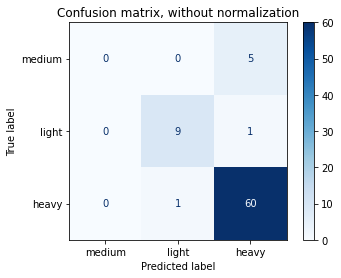

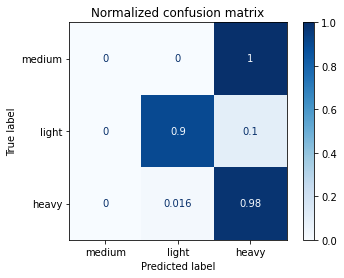

In [10]:
plt_confusion_matrix(logistic_regression)

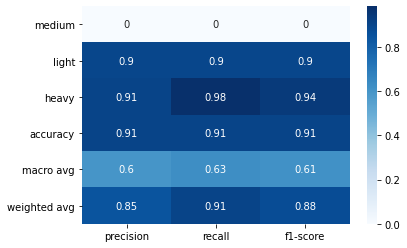

In [11]:
plt_classification_report(logistic_regression)

#### 5.2 Random Forest
***`Add brief explanation.`***

In [12]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

##### 5.2.1 Performance Analysis

In [13]:
clc_accuracy(random_forest)

Mean: 0.85,  STD: 0.03


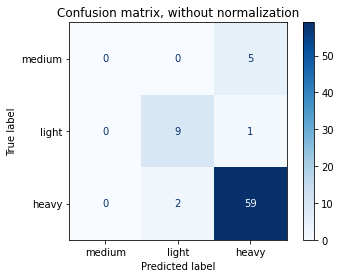

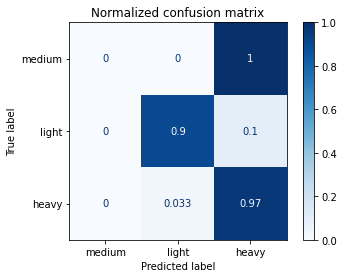

In [14]:
plt_confusion_matrix(random_forest)

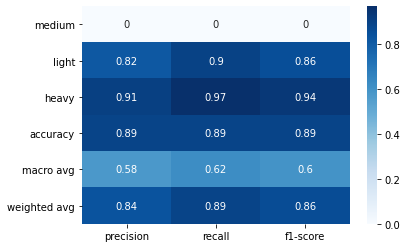

In [15]:
plt_classification_report(random_forest)

#### 5.3 Support Vector Machine
***`Add brief explanation.`***

In [16]:
# Support Vector Machine Classifier
from sklearn.svm import SVC
svc = SVC()

##### 5.3.1 Performance Analysis

In [17]:
clc_accuracy(svc)

Mean: 0.78,  STD: 0.02


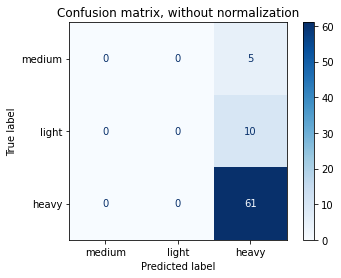

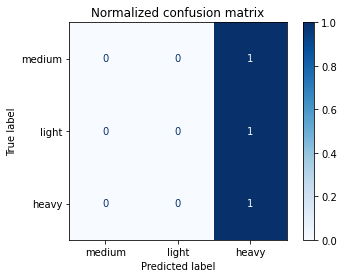

In [18]:
plt_confusion_matrix(svc)

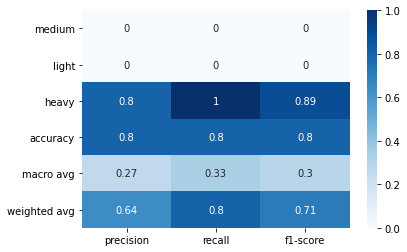

In [19]:
plt_classification_report(svc)

#### 5.4 Multilayer Perceptron

##### 5.4.1 Performance Analysis